# Distributed and Parallel Training Tutorials

torch 中分布式训练可以分为：

- Distributed Data-Parallel Training(DDP), 单程序多数据训练范例，多进程复制多份模型，并且每份模型都会feed 不同的输入samples。DDP 负责梯度通信以保持模型副本同步，并将其与梯度计算重叠以加速训练。
- RPC-Based Distributed Training(RPC)，支持无法适应数据并行训练的通用训练结构，例如分布式管道并行、参数服务器范式、以及 DDP 与其他训练范例的结合。
- Collective Communication(c10d)，c10d函数库支持在组内跨进程发送张量，提供了集体通信 API，比如(all_reduce和all_gather)以及P2P通信API(比如 send 和isend)。DDP和RPC就是建立在c10d函数库之上的。


**数据并行训练**

随着模型规模的增长，可以遵循如下规则使用toch提供的选项：
- 如果单GPU能够运行训练，并且训练速度并不是首要关注的，那么就使用单GPU。
- 使用`DataParallel` 单机多卡的方式，以最小的代码改动，加速训练。
- 如果想要进一步在单机多卡上加速训练，并且愿意做代码改动，可以使用`DistributedDataParallel`来加速单机多卡的训练。
- 使用`DistributedDataParallel` 以及`launching script` 来进行多机多卡的训练。
- 使用`torch.distributed.elastic`来动态调整训练的规模


## torch.nn.DataParallel

最小改动单机多卡，模型复制多份到多个device上去，会将每次forward 的batch scattter平分到多个device上，然后最终将输出的结果通过gather的方式汇总起来。

In [16]:
# DataParallel
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
print(os.environ['CUDA_VISIBLE_DEVICES'])
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

batch_size = 64
data_size = 64
input_size = 40
inter_size = 60
output_size = 20

class RandomDataset(Dataset):

    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(input_size, data_size),
                         batch_size=batch_size, shuffle=True)

class Model(nn.Module):
    def __init__(self, input_size, inter_size, output_size) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=inter_size, bias=True)
        self.fc2 = nn.Linear(in_features=input_size, out_features=inter_size, bias=True)
        self.fc3 = nn.Linear(in_features=inter_size, out_features=output_size, bias=True)
        self.act = nn.SiLU()

    def forward(self, x):
        print(x.shape, x.device)
        return self.fc3(self.fc1(x) + self.act(self.fc2(x)))

print(torch.cuda.device_count())


model = Model(input_size, inter_size, output_size)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for data in rand_loader:
    input = data.to(device)
    output = model(input)
    print("Outside: input size", input.size(), "output_size", output.size())

0,1,2,3
4
Let's use 4 GPUs!
DataParallel(
  (module): Model(
    (fc1): Linear(in_features=40, out_features=60, bias=True)
    (fc2): Linear(in_features=40, out_features=60, bias=True)
    (fc3): Linear(in_features=60, out_features=20, bias=True)
    (act): SiLU()
  )
)
torch.Size([16, 40]) cuda:0
torch.Size([16, 40]) cuda:1
torch.Size([16, 40]) cuda:2
torch.Size([16, 40]) cuda:3
Outside: input size torch.Size([64, 40]) output_size torch.Size([64, 20])


## torch.nn.parallel.DistributedDataParallel

相比`DataParallel`，`DistributedDataParallel`需要额外的一点配置，DDP 使用的是多进程并行

[PyTorch Distributed: Experiences on Accelerating
Data Parallel Training](https://www.vldb.org/pvldb/vol13/p3005-li.pdf)

DDP 分布式场景下，底层使用的gloo(goole tcp/ip)、nccl(nvidia)、mpi(open source)等通信框架协议多机多卡之间通信。

每次前向都是使用分批的数，当反向的时候，每卡都会算自己的梯度，然后将其广播到其他卡上，同时进行reduce操作，求得平均的梯度。

此时平均梯度在每张卡上就是一样的，然后每张卡上的模型也是一致的，所以使用梯度更新之后也是权重一致的。

### 集群通信类型

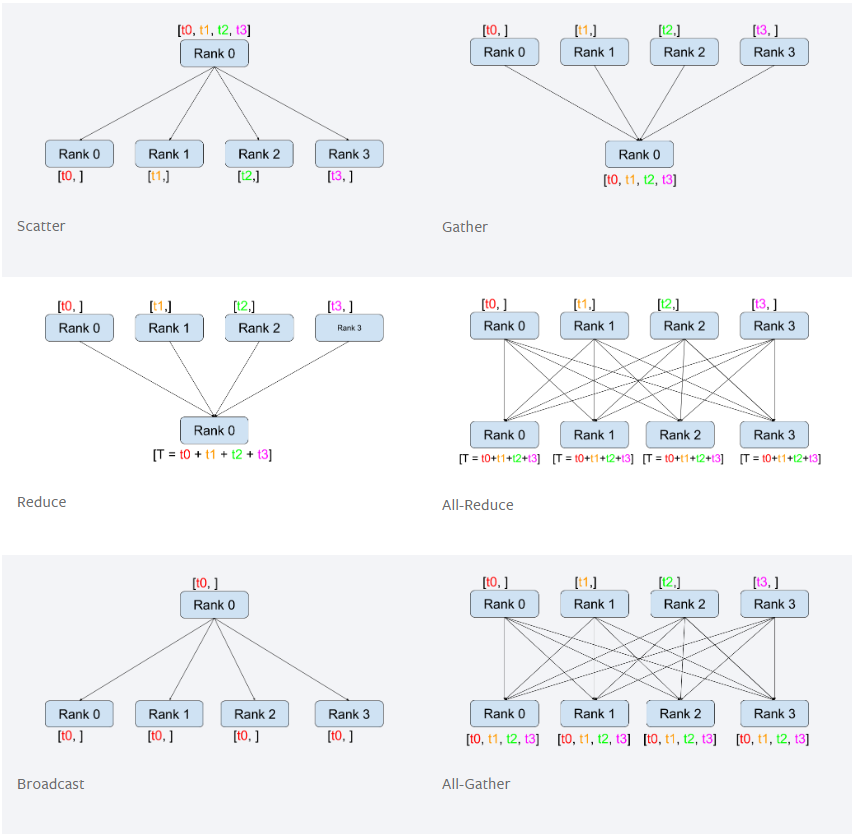



## torchrun

torchrun 提供如下功能：
- 当wroker故障时，重启所有worker
- 自动分配`RANK`和`WORLD_SIZE`
- 动态调整节点个数


常见的用法

单节点多worker

```shell
torchrun
    --nnodes=$NUM_NODES
    --nproc-per-node=$NUM_TRAINERS
    --max-restarts=3
    --rdzv-id=$JOB_ID
    --rdzv-backend=c10d
    --rdzv-endpoint=$HOST_NODE_ADDR
    YOUR_TRAINING_SCRIPT.py (--arg1 ... train script args...)
```

